# Patent Kaggle challenge

notebook from fastai course lesson 4

## Importing kaggle dataset

In [3]:
!kaggle competitions download -c us-patent-phrase-to-phrase-matching
!unzip us-patent-phrase-to-phrase-matching.zip -d us-patent-phrase-to-phrase-matching
!rm us-patent-phrase-to-phrase-matching.zip

In [2]:
from pathlib import Path

path = Path('us-patent-phrase-to-phrase-matching')
!ls {path}

sample_submission.csv  test.csv  train.csv


## Viewing data

In [3]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df.head()

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


In [3]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,8d135da0b55b8c88,component composite coating,composition,H01
freq,1,152,24,2186


In [31]:
df.target.value_counts()

target
composition               24
motor                     22
metal                     22
data                      22
assembly                  21
                          ..
switch over                1
switch off valve           1
switch control valve       1
supply valve               1
flow controlling valve     1
Name: count, Length: 29340, dtype: int64

In [32]:
df['section'] = df.context.str[0]
df.section.value_counts()

section
B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: count, dtype: int64

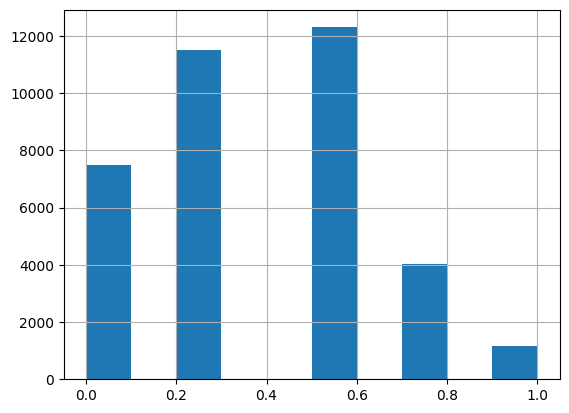

In [37]:
df.score.hist();

In [38]:
df[df.score==1]

,id,anchor,target,context,score,input,section
28,473137168ebf7484,abatement,abating,F24,1.0,TEXT1: abatement; TEXT2: abating; CONTEXT: F24,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,TEXT1: absorbent properties; TEXT2: absorbent ...,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,TEXT1: absorbent properties; TEXT2: absorption...,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,TEXT1: acid absorption; TEXT2: absorption of a...,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,TEXT1: acid absorption; TEXT2: acid absorption...,B
...,...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,TEXT1: wiring trough; TEXT2: wiring troughs; C...,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,TEXT1: wood article; TEXT2: wood articles; CON...,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,TEXT1: wood article; TEXT2: wooden article; CO...,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,TEXT1: wood article; TEXT2: wood article; CONT...,B


In [4]:
df['input'] = 'TEXT1: ' + df.anchor + '; TEXT2: ' + df.target + '; CONTEXT: ' + df.context
df.input.head()

0    TEXT1: abatement; TEXT2: abatement of pollutio...
1    TEXT1: abatement; TEXT2: act of abating; CONTE...
2    TEXT1: abatement; TEXT2: active catalyst; CONT...
3    TEXT1: abatement; TEXT2: eliminating process; ...
4    TEXT1: abatement; TEXT2: forest region; CONTEX...
Name: input, dtype: object

## Tokenisation

In [5]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)
ds = ds.rename_columns({'score':'labels'})
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input'],
    num_rows: 36473
})

In [6]:
model_nm = 'microsoft/deberta-v3-small'
model_nm_variant = 'bert-base-cased'

In [7]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm, use_fast = False)
tokz_variant = AutoTokenizer.from_pretrained(model_nm_variant)

In [19]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

In [22]:
tokz_variant.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['G',
 "'",
 'day',
 'folks',
 ',',
 'I',
 "'",
 'm',
 'Jeremy',
 'from',
 'fast',
 '.',
 'a',
 '##i',
 '!']

In [20]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [21]:
tokz_variant.tokenize("A platypus is an ornithorhynchus anatinus.")

['A',
 'p',
 '##lat',
 '##y',
 '##pus',
 'is',
 'an',
 'or',
 '##ni',
 '##th',
 '##or',
 '##hy',
 '##nch',
 '##us',
 'an',
 '##ati',
 '##nus',
 '.']

In [42]:
sep = tokz_variant.sep_token
sep

'[SEP]'

In [43]:
def tok_func(x): return tokz(x["input"])
tok_ds = ds.map(tok_func, batched=True, 
               remove_columns=('id', 'anchor', 'target', 'context', 'input'))
tok_ds

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [44]:
tok_ds[0]

{'labels': 0.5,
 'input_ids': [1,
  54453,
  435,
  294,
  47284,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  20967,
  104917,
  294,
  336,
  5753,
  2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [52]:
print(len(tokz.vocab))
print(tokz.vocab['▁of'])

128000
265


In [53]:
print(ord('▁'))
print(ord('_'))

9601
95


Test Set 

In [9]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,hybrid bearing,inorganic photoconductor drum,G02
freq,1,2,1,3


### Validation and Test data

Validation dataset

In [10]:
# method 1 : randomly pick items from the training data
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [45]:
# method 2 : randomly select anchor values and pick all rows with this anchor values 
# This way, anchor values do not overlap btween validation and training dataset

In [49]:
anchors = df.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)

val_prop = 0.25
val_sz = int(len(anchors)*val_prop)
val_anchors = anchors[:val_sz]


In [50]:
is_val = np.isin(df.anchor, val_anchors)
idxs = np.arange(len(df))
val_idxs = idxs[is_val]
trn_idxs = idxdds = DatasetDict({"train":tok_ds.select(trn_idxs),
             "test": tok_ds.select(val_idxs)})
s[~is_val]
len(val_idxs),len(trn_idxs)

(9116, 27357)

In [51]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs),
             "test": tok_ds.select(val_idxs)})


In [52]:
df.iloc[trn_idxs].score.mean(),df.iloc[val_idxs].score.mean()

(np.float64(0.3623021530138539), np.float64(0.3613426941641071))

Test dataset

In [11]:
eval_df['input'] = 'TEXT1: ' + eval_df.anchor + '; TEXT2: ' + eval_df.target + '; CONTEXT: ' + eval_df.context
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True, remove_columns=('id', 'anchor', 'target', 'context', 'input'))

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

## Metric

Transformers expect metrics to be returnes as a dictionnary

In [20]:
import numpy as np
def corr(x,y): return np.corrcoef(x,y)[0][1]
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

## Training

In [22]:
from transformers import TrainingArguments,Trainer

In [23]:
bs = 128
epochs = 4
lr = 8e-5

args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    eval_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  processing_class=tokz, compute_metrics=corr_d)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
trainer.train();

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024370,0.799342
2,No log,0.022622,0.826369
3,0.029600,0.021427,0.836033
4,0.029600,0.021958,0.837357


## Predictions

In [28]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds = np.clip(preds, 0, 1)
print(preds)

[[0.52148438]
 [0.64697266]
 [0.52734375]
 [0.31420898]
 [0.        ]
 [0.48803711]
 [0.5234375 ]
 [0.        ]
 [0.22814941]
 [1.        ]
 [0.25390625]
 [0.27758789]
 [0.81054688]
 [0.83935547]
 [0.77197266]
 [0.43334961]
 [0.28637695]
 [0.        ]
 [0.59082031]
 [0.32617188]
 [0.50634766]
 [0.24609375]
 [0.15625   ]
 [0.21435547]
 [0.57958984]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.62402344]
 [0.32543945]
 [0.01121521]
 [0.74169922]
 [0.55859375]
 [0.38305664]
 [0.23498535]]


In [29]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1021